In [1]:
import torch
from PIL import Image
import clip

In [19]:
model = clip.load('vit_v0.pth')

/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/clip/clip.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(opened_file, map_locat

EOFError: Ran out of input

In [62]:
import pandas as pd
df = pd.read_csv('data/data.csv')

df_test = df[(df['tag']=='test')]
len(df_test)

197

In [63]:
df_test.head()

,file_name,label,img_path,tag
11,45_DSCN6721,Leukoplakia,data/test/images/45_DSCN6721.jpg,test
12,61_DSCN2291,Leukoplakia,data/test/images/61_DSCN2291.jpg,test
16,91_DSCN9724,Ulcer,data/test/images/91_DSCN9724.jpg,test
17,51_IMG_0803,Keratosis,data/test/images/51_IMG_0803.jpg,test
22,80_IMG_0108,Leukoplakia,data/test/images/80_IMG_0108.jpg,test


In [28]:
import torch
import clip
from PIL import Image
import os
import matplotlib.pyplot as plt 

In [107]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model and preprocessing pipeline
model, preprocess = clip.load("ViT-B/32", device=device)
# model, preprocess = clip.load("./vit_v0.pth", device=device)


/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/clip/clip.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(opened_file, map_locat

EOFError: Ran out of input

In [53]:
def predict(image_path, labels):

    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = torch.cat([clip.tokenize(f"{c}") for c in labels]).to(device)
    # Perform inference
    with torch.no_grad():
        # Encode image and text
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        # Calculate similarity scores between image and text
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        # Normalize image and text features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(len(labels))

        return {labels[l]: float(value) for l, value in zip(indices, values)}

In [54]:
labels = list(set(df['label']))
print('lables: ',labels)

lables:  ['Erythroleukoplakia', 'Leukoplakia', 'Ulcer', 'Erythroplakia', 'Tumor', 'Keratosis']


In [58]:
image_path = df['img_path'].iloc[0]
pred = predict(image_path, labels)
pred

{'Leukoplakia': 0.85693359375,
 'Erythroleukoplakia': 0.11962890625,
 'Ulcer': 0.01953125,
 'Tumor': 0.0021915435791015625,
 'Erythroplakia': 0.0012683868408203125,
 'Keratosis': 0.00061798095703125}

In [60]:
# # Display the image with its class label
# plt.imshow(plt.imread(image_path))
# plt.title(f"Image for class: {image_class}")
# plt.axis('off')
# plt.show()

In [73]:
y_true = []
y_pred = []

for i in range(len(df_test)):
    image_path = df_test['img_path'].iloc[i]
    actual_label = df_test['label'].iloc[i]

    predicted_topk = predict(image_path, labels)
    predicted_label = max(zip(predicted_topk.values(), predicted_topk.keys()))

    y_true.append(actual_label)
    y_pred.append(predicted_label[1])
    

In [74]:
y_pred[0], y_true[0]

('Leukoplakia', 'Leukoplakia')

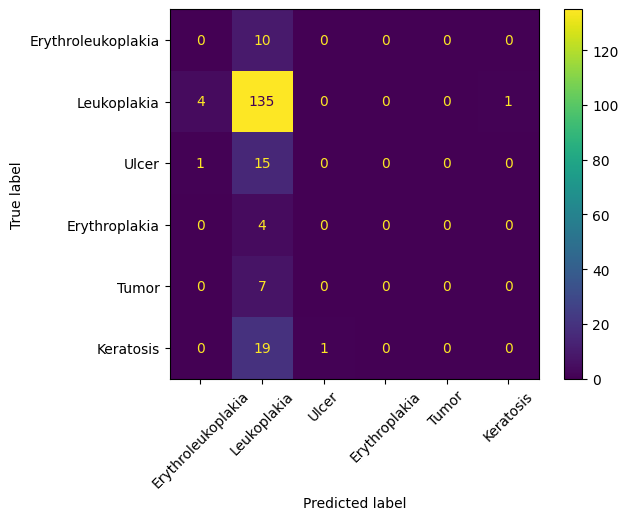

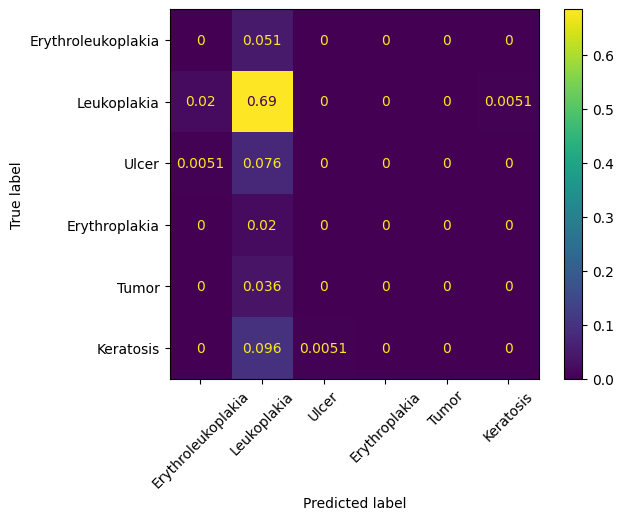

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_normalise = confusion_matrix(y_true, y_pred, labels=labels,  normalize='all')
cm = ConfusionMatrixDisplay(cm , display_labels=labels)
cm.plot(xticks_rotation=45)

cm_normalise = ConfusionMatrixDisplay(cm_normalise , display_labels=labels)
cm_normalise.plot(xticks_rotation=45)

In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, labels=labels))


                    precision    recall  f1-score   support

Erythroleukoplakia       0.00      0.00      0.00        10
       Leukoplakia       0.71      0.96      0.82       140
             Ulcer       0.00      0.00      0.00        16
     Erythroplakia       0.00      0.00      0.00         4
             Tumor       0.00      0.00      0.00         7
         Keratosis       0.00      0.00      0.00        20

          accuracy                           0.69       197
         macro avg       0.12      0.16      0.14       197
      weighted avg       0.50      0.69      0.58       197



/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()